In [1]:
import numpy as np
import pandas as pd
import random
import os
import time
import pickle
from pathlib import Path

from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score

#import lightgbm as lgb
import xgboost as xgb
#import catboost as ctb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

# Parameters

In [2]:
target = 'claim'

DEBUG = False

if DEBUG:
    N_ESTIMATORS = 1
    N_SPLITS = 2
    SEED = 2017
    CVSEED = 2017
    EARLY_STOPPING_ROUNDS = 1
    VERBOSE = 100
    #N_ITERS = 2
else:
    N_SPLITS = 10
    N_ESTIMATORS = 20000
    EARLY_STOPPING_ROUNDS = 300
    VERBOSE = 1000
    SEED = 2017
    CVSEED = 2017
    #N_ITERS = 10

In [3]:
def set_seed(seed=2017):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
set_seed(SEED)

# Datasets

In [4]:
INPUT = Path("../input/tabular-playground-series-sep-2021")

train = pd.DataFrame(pd.read_csv(INPUT / "train.csv")[target])
#test = pd.read_csv(INPUT / "test.csv")
test = pd.DataFrame()
submission = pd.read_csv(INPUT / "sample_solution.csv")

In [5]:
train['lgb_pred'] = np.load("../input/tps-sep-lv0-base-trees/agg_lgb_oof.npy")
test['lgb_pred'] = np.load("../input/tps-sep-lv0-base-trees/agg_lgb_pred.npy")

train['lgb2_pred'] = np.load("../input/tps-sep-lv0-base-trees/agg_lgb2_oof.npy")
test['lgb2_pred'] = np.load("../input/tps-sep-lv0-base-trees/agg_lgb2_pred.npy")

train['xgb_pred'] = np.load("../input/tps-sep-lv0-base-trees/agg_xgb_oof.npy")
test['xgb_pred'] = np.load("../input/tps-sep-lv0-base-trees/agg_xgb_pred.npy")

train['lgb_bizen_pred'] = np.load("../input/tps-sep-lv0-base-trees/lgb_bizen_oof.npy")
test['lgb_bizen_pred'] = np.load("../input/tps-sep-lv0-base-trees/lgb_bizen_pred.npy")

train['lgb_dmitry_pred'] = np.load("../input/tps-sep-lv0-base-trees/lgb_dmitry_oof.npy")
test['lgb_dmitry_pred'] = np.load("../input/tps-sep-lv0-base-trees/lgb_dmitry_pred.npy")

train['xgb_dmitry_pred'] = np.load("../input/tps-sep-lv0-base-trees/xgb_dmitry_oof.npy")
test['xgb_dmitry_pred'] = np.load("../input/tps-sep-lv0-base-trees/xgb_dmitry_pred.npy")

train['lgb_manav_pred'] = np.load("../input/tps-sep-lv0-base-trees/lgb_manav_oof.npy")
test['lgb_manav_pred'] = np.load("../input/tps-sep-lv0-base-trees/lgb_manav_pred.npy")

train['xgb_manav_pred'] = np.load("../input/tps-sep-lv0-base-trees/xgb_manav_oof.npy")
test['xgb_manav_pred'] = np.load("../input/tps-sep-lv0-base-trees/xgb_manav_pred.npy")

In [6]:
train['ridge_pred'] = np.load("../input/tps-sep-lv0-base-trees/ridge_oof.npy")
test['ridge_pred'] = np.load("../input/tps-sep-lv0-base-trees/ridge_pred.npy")

# Preprocessing

In [7]:
features = [col for col in train.columns if 'pred' in col]

In [8]:
ss = StandardScaler()

In [9]:
test[features]

,lgb_pred,lgb2_pred,xgb_pred,lgb_bizen_pred,lgb_dmitry_pred,xgb_dmitry_pred,lgb_manav_pred,xgb_manav_pred,ridge_pred
0,0.558734,0.578699,0.576973,0.561836,0.566536,0.575204,0.564575,0.564908,0.553440
1,0.130124,0.120648,0.124073,0.119917,0.126946,0.126340,0.121656,0.120459,0.182040
2,0.634854,0.628457,0.630655,0.629326,0.627686,0.635330,0.626681,0.633499,0.631720
3,0.121661,0.125785,0.126651,0.128635,0.122506,0.123506,0.128684,0.131022,0.184237
4,0.151700,0.150161,0.149483,0.153291,0.146343,0.143437,0.152862,0.153132,0.203202
...,...,...,...,...,...,...,...,...,...
493469,0.833647,0.829336,0.829659,0.827457,0.825696,0.827184,0.831222,0.816129,0.790480
493470,0.114116,0.116351,0.117947,0.111374,0.112238,0.115928,0.111981,0.109487,0.174385
493471,0.771955,0.760704,0.758474,0.758873,0.764026,0.754300,0.756039,0.774203,0.751130
493472,0.129603,0.132275,0.129645,0.133944,0.135123,0.132036,0.135098,0.136081,0.184900


In [10]:
train[target]

0         1
1         0
2         1
3         1
4         1
         ..
957914    0
957915    1
957916    0
957917    1
957918    0
Name: claim, Length: 957919, dtype: int64

# XGB

In [11]:
xgb_params = {
            'objective': 'binary:logistic',                   
          'n_estimators':N_ESTIMATORS,                   
          'importance_type': 'total_gain',               
          'booster': 'gbtree',                   
          'n_jobs' : -1,                
          'tree_method': 'hist',    
    
     'learning_rate': 0.01805802806162393,
     'subsample': 0.4014133642323718,
     'colsample_bytree': 0.9129261289649728,
     'reg_lambda': 0.4746414387266343,
     'reg_alpha': 0.21152645002896442,
     'min_child_weight': 28.051170865462655,
     'max_depth': 2,
     'max_bin': 552,
     'gamma': 8.244492575974531
}

In [12]:
xgb_oof = np.zeros(train.shape[0])
xgb_pred = np.zeros(test.shape[0])
xgb_importances = pd.DataFrame()


kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=CVSEED)
seed_list=range(SEED, SEED+20)

for fold, (trn_idx, val_idx) in enumerate(kf.split(X=train[features], y=train[target])):
    print(f"===== fold {fold} =====")


    X_train = train[features].iloc[trn_idx]
    y_train = train[target].iloc[trn_idx]
    X_valid = train[features].iloc[val_idx]
    y_valid = train[target].iloc[val_idx]
    X_test = test[features]
      
        
    X_train[features] = ss.fit_transform(X_train[features])
    X_valid[features] = ss.transform(X_valid[features])
    X_test[features] = ss.transform(X_test[features])

    start = time.time()
    for inseed in seed_list:
        xgb_params['random_state'] = inseed

        pre_model = xgb.XGBClassifier(**xgb_params)
        pre_model.fit(
            X_train, 
            y_train,
            eval_set=[(X_valid, y_valid)],
            eval_metric='auc',
            early_stopping_rounds=EARLY_STOPPING_ROUNDS,
            verbose=VERBOSE,
        )

        xgb_params2 = xgb_params.copy()
        xgb_params2['reg_lambda'] *= 0.9
        xgb_params2['reg_alpha'] *= 0.9
        xgb_params2['learning_rate'] *= 0.1
        model = xgb.XGBClassifier(**xgb_params2)
        model.fit(
                X_train, y_train,
                eval_set=[(X_valid, y_valid)],
                eval_metric='auc',
                early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                verbose=VERBOSE,
                xgb_model=pre_model
        )    

        with open(f"xgb_model{fold}_seed{inseed}.pkl", 'wb') as f:
            pickle.dump(model, f)

        fi_tmp = pd.DataFrame()
        fi_tmp['feature'] = X_train.columns
        fi_tmp['importance'] = model.feature_importances_
        fi_tmp['fold'] = fold
        fi_tmp['seed'] = inseed
        xgb_importances = xgb_importances.append(fi_tmp)

        xgb_oof[val_idx] += model.predict_proba(X_valid)[:,-1] / len(seed_list)
        xgb_pred += model.predict_proba(X_test)[:,-1] / len(seed_list)


    elapsed = time.time() - start
    auc = roc_auc_score(y_valid, xgb_oof[val_idx])
    print(f"fold {fold} - xgb auc: {auc:.6f}, elapsed time: {elapsed:.2f}sec\n")            

xgb_pred /= N_SPLITS
print(f"oof xgb_auc = {roc_auc_score(train[target], xgb_oof)}")

np.save("xgb_oof.npy", xgb_oof)
np.save("xgb_pred.npy", xgb_pred)

===== fold 0 =====
[0]	validation_0-auc:0.80461
[827]	validation_0-auc:0.81730
[0]	validation_0-auc:0.81730
[299]	validation_0-auc:0.81730
[0]	validation_0-auc:0.80461
[1000]	validation_0-auc:0.81736
[1605]	validation_0-auc:0.81737
[0]	validation_0-auc:0.81737
[517]	validation_0-auc:0.81737
[0]	validation_0-auc:0.80441
[1000]	validation_0-auc:0.81734
[1082]	validation_0-auc:0.81733
[0]	validation_0-auc:0.81734
[560]	validation_0-auc:0.81733
[0]	validation_0-auc:0.80490
[1000]	validation_0-auc:0.81734
[1040]	validation_0-auc:0.81735
[0]	validation_0-auc:0.81735
[300]	validation_0-auc:0.81734
[0]	validation_0-auc:0.80319
[879]	validation_0-auc:0.81736
[0]	validation_0-auc:0.81736
[341]	validation_0-auc:0.81736
[0]	validation_0-auc:0.80390
[1000]	validation_0-auc:0.81733
[1690]	validation_0-auc:0.81736
[0]	validation_0-auc:0.81736
[325]	validation_0-auc:0.81735
[0]	validation_0-auc:0.80417
[851]	validation_0-auc:0.81731
[0]	validation_0-auc:0.81731
[300]	validation_0-auc:0.81731
[0]	valid

# OOF predictions

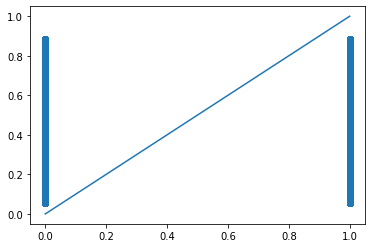

In [13]:
plt.plot(train[target], train[target])
plt.scatter(train[target], xgb_oof)

# Features importances

Text(0.5, 1.0, 'LightGBM feature importances')

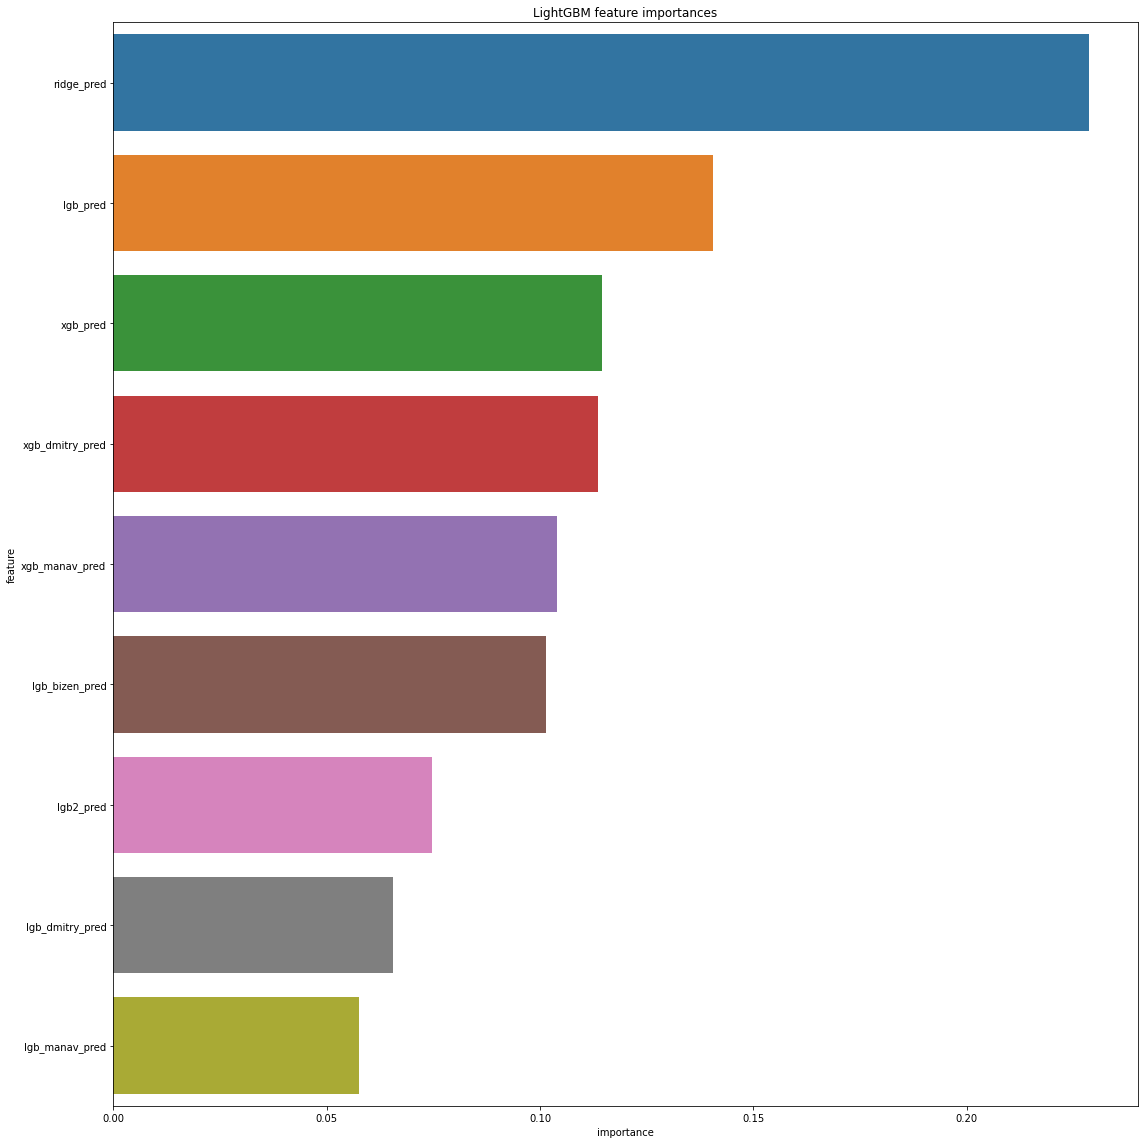

In [14]:
order = list(xgb_importances.groupby('feature').mean().sort_values('importance', ascending=False).index)

fig = plt.figure(figsize=(16, 16), tight_layout=True)
sns.barplot(x="importance", y="feature", data=xgb_importances.groupby('feature').mean().reset_index(), order=order)
plt.title("LightGBM feature importances")

# Submission

In [15]:
submission[target] = xgb_pred
submission.to_csv("submission.csv", index=False)

submission

,id,claim
0,957919,0.569610
1,957920,0.122720
2,957921,0.627649
3,957922,0.128085
4,957923,0.157738
...,...,...
493469,1451388,0.831848
493470,1451389,0.110959
493471,1451390,0.775066
493472,1451391,0.130700


# Log

/////// 8 trees + ridge /////////

